In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"           
import scipy.io as sio
import sys                                                                              
import h5py as hp
import argparse
import random           
import numpy as np
import cv2
from random import choices, choice
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from IPython.display import HTML, display, Image
from numpy.fft import ifft2,fft2,fft,ifft,fftfreq, fftshift,ifftshift

from IPython.display import HTML, display, Image
import time
from tqdm.auto import tqdm
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.signal import convolve2d, correlate2d
from scipy.optimize import curve_fit
import scipy 

import torch
import math
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from tifffile import imread
from torchsummary import summary
from torch.nn.utils import spectral_norm
import itertools


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def rebin1d(arr, new_shape):
    shape = (new_shape, arr.shape[0] // new_shape)
    return arr.reshape(shape).mean(-1)

def normalize(x):
    return (x-np.amin(x))/(np.amax(x)-np.amin(x))#x/np.amax(x)#
def normalize_t(x):
    return (x-torch.amin(x))/(torch.amax(x)-torch.amin(x))#x/np.amax(x)#


def centralpadding(arr, new_shape):
    if new_shape[0]>=arr.shape[0]:
        newarr = np.zeros(new_shape,dtype=complex)
        newarr[(new_shape[0] - arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (new_shape[1] - arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ] = arr
    else:
        newarr= arr[(-new_shape[0] + arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (-new_shape[1] + arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ]
    return newarr

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def moving_average_smooth(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec
def autocor2d(I):
    f = fft2(I)
    f = np.absolute(f)**2
    autocor2d = ifftshift(ifft2(f))/I.shape[0]/I.shape[1]
    return autocor2d
def autocor2d_t(I):
#     f = torch.absolute(torch.fft.fft2(I))**2

#     autocor2d = torch.fft.ifftshift(torch.fft.ifft2( torch.absolute(torch.fft.fft2(I))**2))/I.shape[0]/I.shape[1]
    return  torch.fft.ifftshift(torch.fft.ifft2( torch.absolute(torch.fft.fft2(I))**2),dim=(-2,-1))/I.shape[-1]/I.shape[-2]

def axis1norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[0]):
        Y[i,:] = X[i,:]/np.mean(X[i,:]**1)
    return Y

def axis0norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[1]):
        Y[:,i] = X[:,i]/np.mean(X[:,i]) 
    return Y

def ReLU(x):
    return x * (x > 0)
#load exp data

filename = [#one interval
#             "../expdata/mesh_1_220710/220710_153Z_MCC_less45_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153S_KCl_below106_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153L_KCl_106-180_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153A_KCl_180-250_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153B_KCl_250-300_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153D_KCl_355-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153E_KCl_425-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153I_KCl_above500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #two interval
            "../expdata/mesh_1_220710/220710_153P_KCl_106-250_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153K_KCl_180-300_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153F_KCl_250-355_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153G_KCl_300-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153M_KCl_355-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #three interval
            "../expdata/mesh_1_220710/220710_153N_KCl_180-355_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153T_KCl_250-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153R_KCl_355-1000_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #four interval
            "../expdata/mesh_1_220710/220710_153Q_KCl_180-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "../expdata/mesh_1_220710/220710_153O_KCl_250-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #five interval
            "../expdata/mesh_1_220710/220710_153H_KCl_180-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",    
            ]
basefilename =  "../expdata/mesh_1_220710/220710_153Z_MCC_less45_500frame_200us_0ms_180GAN_bin2.npz_auto.npz"
basename = '<45 um'            
name = [#one interval
#         '<45 μm',
        '0-106 um',
        '106-180 um',
        '180-250 um',
        '250-300 um',
#         '300-355 μm',
        '355-425 um',
        '425-500 um',
        '500-1000 um',
        #two interval
        '106-250 um',
        '180-300 um',
        '250-355 um',
        '300-425 um',
        '355-500 um',
        #three interval
        '180-355 um',
        '250-425 um',
        '355-1000 um',
        #four interval
        '180-425 um',
        '250-500 um',
        #five interval
        '180-500 um']

# 

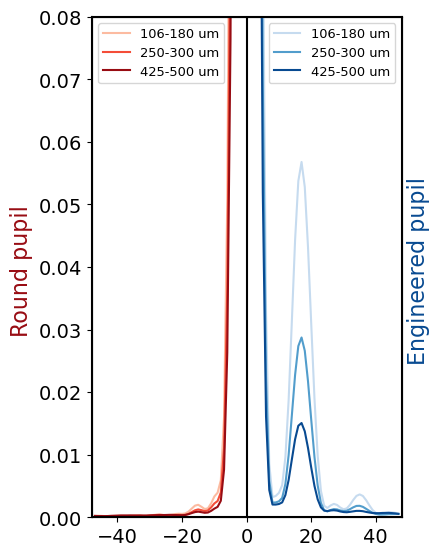

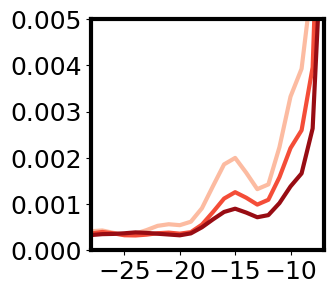

In [5]:
shaped_pupil_linecutplotfile = [
    "expdata/shaped_pupil_1Dauto_plot_auto106-180 um.npz",
#     "../expdata/1Dauto_plot_auto~180-250um.npz",
    "expdata/shaped_pupil_1Dauto_plot_auto250-300 um.npz",
#     "../expdata/1Dauto_plot_auto~355-425um.npz",
    "expdata/shaped_pupil_1Dauto_plot_auto425-500 um.npz",
]

linecutplotfile = [
    "expdata/1Dauto_plot_auto~106-180um.npz",
#     "../expdata/1Dauto_plot_auto~180-250um.npz",
    "expdata/1Dauto_plot_auto~250-300um.npz",
#     "../expdata/1Dauto_plot_auto~355-425um.npz",
    "expdata/1Dauto_plot_auto~425-500um.npz",
]
circle_pupil_1d = np.zeros((5,96))
for i in range(len(linecutplotfile)):
    circle_pupil_1d[i] = np.load(linecutplotfile[i])['autolinecut']#+0.0005
# circle_pupil_1d[:,48:]=0

shaped_pupil_1d = np.zeros((5,96))
for i in range(len(shaped_pupil_linecutplotfile)):
    shaped_pupil_1d[i] = np.load(shaped_pupil_linecutplotfile[i])['autolinecut']
# shaped_pupil_1d[:,:48]=0

cmap = plt.get_cmap('Reds')
colors = [cmap(i) for i in np.linspace(0.25, 0.9, 3)]

# plt.figure(figsize=(5,5),facecolor='w')
fig,ax = plt.subplots(figsize=(4,6.5),facecolor='w')
# fig,ax = plt.subplots(figsize=(5,6.5),facecolor='w')

for t in range(3):
    ax.plot(-np.flip(np.arange(48)),(circle_pupil_1d[t,1:49]+0.0000)**1,color=colors[t],label=name[t*2+1])
ax.set_ylim(0,0.08)
ax.set_ylabel('Round pupil ',fontsize=16,color=colors[2])


ax.tick_params(axis="x", labelsize=14) 
ax.tick_params(axis="y", labelsize=14) 
ax.legend(prop={'size': 9.4},loc="upper left")

cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0.25, 0.9, 3)]

ax2=ax.twinx()
for t in range(3):
    ax2.plot(np.arange(48),shaped_pupil_1d[t,48:]**1,'-',color=colors[t],label=name[t*2+1])
        
plt.axvline(x = 0., color = 'k', linestyle = '-', linewidth=1.5)
plt.xlabel('Pixel',fontsize=16)
ax2.set_ylabel('Engineered pupil ',fontsize=16,color=colors[2])
ax2.set_ylim(0,0.08)
ax2.tick_params(axis="x", labelsize=14) 
ax2.tick_params(axis="y", labelsize=0) 
ax2.set_yticks([])

# ax2.set_yticks([],labelsize=0) 

# ax2.tick_params(axis="y", labelsize=0) 
ax2.legend(prop={'size': 9.4},loc="upper right")
plt.xlim(-48,48)
# plt.title(name[t*4+k-2], y=1, pad=18 ,color='k',fontsize=16)
    # plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.title("up:measurement; down:calculation @ " + name[plot_idx])
# #     plt.axis('off')
#     plt.xticks([])    
[x.set_linewidth( 1.5) for x in plt.gca().spines.values()]
fig.savefig('figures/fig_2b_1.pdf', dpi='figure', format=None)



cmap = plt.get_cmap('Reds')
colors = [cmap(i) for i in np.linspace(0.25, 0.9, 3)]
fig = plt.figure(figsize=(3,3),facecolor='w')
for t in range(3):
    plt.plot(-np.flip(np.arange(48)),(circle_pupil_1d[t,1:49]+0.0000)**1,color=colors[t],label=name[t*2+1],
            linewidth=3)
plt.ylim(0,0.005)
plt.xlim(-28,-7)
plt.xticks( fontsize=18) 
plt.yticks(  fontsize=18) 
# ax.legend(prop={'size': 10},loc="upper left")
[x.set_linewidth( 3) for x in plt.gca().spines.values()]

fig.savefig('figures/fig_2b_2.pdf', dpi='figure', format=None)